# Análisis Financiero de Empresas

## Introducción

Este notebook es una herramienta dual diseñada para el análisis de instrumentos cotizados. Ofrece dos rutas de operación distintas: un generador de reportes automatizado y un entorno de análisis interactivo detallado.

## Metodología de Uso

Por favor, elija la modalidad que mejor se adapte a sus objetivos:

### **Opción 1: Reporte Ejecutivo Automatizado (Solo Excel)**

Si su único objetivo es obtener un reporte consolidado en Excel con los datos financieros clave de una empresa, siga este procedimiento.

**Procedimiento:**
1.  Ejecute únicamente la **Celda 0 (Panel de Control)**, ubicada debajo de este texto.
2.  Introduzca el **Ticker** del instrumento. Si es una acción mexicana, asegúrese de incluir el sufijo `.MX` (ej. `AAPL` o `GFINBURO.MX`).
3.  Seleccione el **rango de fechas** deseado para el historial de precios.
4.  Presione el botón **"Generar Análisis y Descargar Excel"**.

**Resultado:**
Se iniciará una descarga automática de un archivo Excel (`.xlsx`) estructurado en cinco pestañas (Info, Balance, E. Resultados, Flujo, Precios), listo para su uso inmediato. No es necesario ejecutar ninguna otra celda.


### **Opción 2: Análisis Interactivo Detallado (Visualización en Colab)**

Si su objetivo es explorar visualmente los datos, comprender la metodología de análisis, o calcular métricas de riesgo y desempeño avanzadas (como Alpha, Beta, VaR, etc.), siga este procedimiento.

**Procedimiento:**
1.  **Ignore la Celda 0.**
2.  Comience a ejecutar las celdas secuencialmente a partir de la **Celda 1 (Configuración Inicial)**.
3.  En la **Celda 2 (Input del Ticker)**, introduzca el símbolo de la acción (recuerde usar el sufijo `.MX` para acciones mexicanas, ej. `GFINBURO.MX`).
4.  Continúe ejecutando las celdas de análisis subsecuentes.

**Resultado:**
Cada celda se ejecutará de forma independiente, descargando los datos específicos que necesita en el momento. Esto le permitirá:
* Visualizar tablas de datos formateadas.
* Generar gráficas de precios y análisis de *drawdown*.
* Calcular métricas de riesgo y desempeño avanzadas.
* Revisar información de analistas y tenedores institucionales.


## Instrucciones para Iniciar

* **Para el Reporte en Excel:** Ejecute la **Celda 0** (abajo).
* **Para el Análisis Interactivo:** Siga a la **Celda 1**.

# Celda 0: Panel de Control (Reporte Automatizado)

Esta celda contiene todo el código necesario para ejecutar la **Opción 1**. Es un script integral "todo en uno" que instala librerías, define la lógica de extracción y genera la interfaz de usuario. No depende de ninguna otra celda de este notebook.

## Componentes de esta Celda

El código está estructurado en las siguientes partes lógicas:

1.  **Instalación Silenciosa:**
    * El script primero comprueba si las bibliotecas requeridas (`yfinance`, `xlsxwriter`, `statsmodels`, etc.) están presentes en el entorno.
    * Si falta alguna, la instala automáticamente de forma silenciosa, sin mostrar los mensajes de instalación, para agilizar ejecuciones futuras.

2.  **Importación de Módulos:**
    * Carga todas las herramientas de Python necesarias para el análisis de datos (`pandas`, `numpy`), la conexión a APIs (`yfinance`, `requests`), la creación de la interfaz (`ipywidgets`) y la generación de archivos (`files`, `io`).

3.  **Definición de la Función Principal (`run_full_analysis_and_download`):**
    * Esta es la función central que se activa al presionar el botón **"Generar Análisis y Descargar Excel"**.
    * **Extracción de Datos:** Se conecta a la API de Yahoo Finance para descargar el perfil de la compañía, los ratios clave, los tres estados financieros y el historial de precios.
    * **Limpieza de Datos:** Procesa los datos, eliminando valores nulos (`NaN`) y, crucialmente, eliminando la información de zona horaria (`tz_localize(None)`) de todas las fechas para prevenir errores de compatibilidad con Excel.
    * **Generación de Excel:** Construye el archivo `.xlsx` con las 5 pestañas solicitadas.
    * **Formateo Avanzado:** Utiliza `xlsxwriter` para aplicar formatos de **número** (moneda, porcentaje, entero) directamente en el Excel. Esto asegura que los datos sigan siendo numéricos y puedan ser utilizados en fórmulas.
    * **Ajuste de Estilo:** Configura los anchos de columna (ej. 50 para E. Resultados, 40 para otros) y elimina encabezados y columnas innecesarias (como `Volume`) para un reporte limpio.
    * **Descarga:** Guarda el archivo y utiliza `files.download()` para enviarlo directamente a su navegador.

4.  **Visualización de Widgets:**
    * La parte final del script genera y muestra la interfaz de usuario que ves: el campo de texto del Ticker, los selectores de fecha y el botón de ejecución.

In [ ]:
import importlib.util
import subprocess
import os

needed_packages = ['yfinance', 'curl_cffi', 'xlsxwriter', 'statsmodels', 'yahooquery']
missing = [pkg for pkg in needed_packages if importlib.util.find_spec(pkg) is None]

if missing:
    subprocess.run(
        f"pip install {' '.join(missing)}",
        shell=True,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

import yfinance as yf
import pandas as pd
import requests
import datetime
from datetime import datetime, timedelta

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from google.colab import files
import io

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

g_last_start_date = datetime.now().date() - timedelta(days=365)
g_last_end_date = datetime.now().date()
g_last_ticker = 'AAPL'

stock = None
info_empresa = None
df_ratios = None
df_balance = None
df_income = None
df_cashflow = None
df_history = None

def run_full_analysis_and_download(sender):
    global stock, info_empresa, df_ratios, df_balance, df_income, df_cashflow, df_history
    global g_last_ticker
    global g_last_start_date, g_last_end_date

    ticker = ticker_input.value.upper()
    start_date_excel = date_picker_start.value
    end_date_excel = date_picker_end.value

    g_last_ticker = ticker
    g_last_start_date = start_date_excel
    g_last_end_date = end_date_excel

    with output_area:
        clear_output(wait=True)

        if not start_date_excel or not end_date_excel or start_date_excel >= end_date_excel:
            print("❌ Error: Revisa las fechas. La fecha de inicio debe ser anterior a la fecha de fin.")
            return

        try:
            stock = yf.Ticker(ticker)
            info_empresa = stock.info
            if not info_empresa or info_empresa.get('regularMarketPrice') is None:
                raise Exception("Ticker no encontrado o sin datos ('info' está vacío)")

            company_name = info_empresa.get('longName', ticker)

            desc_data = {
                'Nombre': info_empresa.get('longName', 'N/A'),
                'Precio Actual': info_empresa.get('regularMarketPrice', np.nan),
                'Sector': info_empresa.get('sector', 'N/A'),
                'Industria': info_empresa.get('industry', 'N/A'),
                'País': info_empresa.get('country', 'N/A'),
                'Sitio Web': info_empresa.get('website', 'N/A'),
                'Descripción': info_empresa.get('longBusinessSummary', 'N/A'),
                ' ': ' '
            }

            metric_map = {
                'marketCap': 'Capitalización de Mercado', 'enterpriseValue': 'Valor de Empresa (EV)',
                'sharesOutstanding': 'Acciones en Circulación', 'beta': 'Beta (Volatilidad)',
                'trailingPE': 'P/E (TTM)', 'forwardPE': 'P/E (Estimado)', 'priceToBook': 'Precio / Valor en Libros (P/B)',
                'priceToSalesTrailing12Months': 'Precio / Ventas (TTM)', 'enterpriseToEbitda': 'EV / EBITDA',
                'trailingEps': 'EPS (Ganancias por Acción, TTM)', 'forwardEps': 'EPS (Estimado)',
                'dividendYield': 'Rendimiento por Dividendo', 'payoutRatio': 'Payout Ratio',
                'profitMargins': 'Margen de Utilidad (Neto)', 'operatingMargins': 'Margen Operativo',
                'returnOnEquity': 'Retorno sobre Capital (ROE)', 'debtToEquity': 'Deuda / Capital (D/E)',
                'totalDebt': 'Deuda Total', 'totalCash': 'Efectivo Total', 'ebitda': 'EBITDA',
                'fiftyTwoWeekLow': 'Mínimo 52 Semanas',
                'fiftyTwoWeekHigh': 'Máximo 52 Semanas'
            }
            ratios_data = {label: info_empresa.get(key, np.nan) for key, label in metric_map.items()}

            combined_info = {**desc_data, **ratios_data}
            df_ratios = pd.Series(combined_info, name='Valor').to_frame()
            df_ratios.index.name = 'Métrica'

            df_balance = stock.balance_sheet.dropna(axis=1, thresh=10).fillna(0)
            df_income = stock.financials.dropna(axis=1, thresh=10).fillna(0)
            df_cashflow = stock.cashflow.dropna(axis=1, thresh=10).fillna(0)

            if pd.api.types.is_datetime64_any_dtype(df_balance.columns) and df_balance.columns.tz is not None:
                df_balance.columns = df_balance.columns.tz_localize(None)
                df_income.columns = df_income.columns.tz_localize(None)
                df_cashflow.columns = df_cashflow.columns.tz_localize(None)

            df_history = stock.history(start=start_date_excel, end=end_date_excel)

            if pd.api.types.is_datetime64_any_dtype(df_history.index) and df_history.index.tz is not None:
                df_history.index = df_history.index.tz_localize(None)

            filename = f"Estados Financieros {company_name}.xlsx"

            output_buffer = io.BytesIO()

            with pd.ExcelWriter(output_buffer, engine='xlsxwriter', datetime_format='yyyy-mm-dd') as writer:

                workbook = writer.book

                format_currency_0dec = workbook.add_format({'num_format': '$#,##0'})
                format_currency_2dec = workbook.add_format({'num_format': '$#,##0.00'})
                format_integer = workbook.add_format({'num_format': '#,##0'})
                format_percent = workbook.add_format({'num_format': '0.00%'})
                format_ratio = workbook.add_format({'num_format': '0.00'})
                format_text_wrap = workbook.add_format({'valign': 'top'})

                df_ratios.to_excel(writer, sheet_name='Info de la empresa', index=True, header=False)
                worksheet1 = writer.sheets['Info de la empresa']
                worksheet1.set_column('A:A', 30)
                worksheet1.set_column('B:B', 20)

                for i, (metric, value_row) in enumerate(df_ratios.iterrows()):
                    row_idx = i
                    value = value_row.get('Valor')

                    if metric == 'Descripción':
                        worksheet1.write_string(row_idx, 1, str(value), format_text_wrap)
                    elif metric == ' ':
                        pass
                    elif metric in ['Capitalización de Mercado', 'Valor de Empresa (EV)', 'Acciones en Circulación', 'Deuda Total', 'Efectivo Total', 'EBITDA']:
                        worksheet1.write_number(row_idx, 1, value, format_integer)
                    elif metric in ['Precio Actual', 'Máximo 52 Semanas', 'Mínimo 52 Semanas', 'EPS (Ganancias por Acción, TTM)', 'EPS (Estimado)']:
                        worksheet1.write_number(row_idx, 1, value, format_currency_2dec)
                    elif metric in ['Rendimiento por Dividendo', 'Payout Ratio', 'Margen de Utilidad (Neto)', 'Margen Operativo', 'Retorno sobre Capital (ROE)']:
                        worksheet1.write_number(row_idx, 1, value, format_percent)
                    elif metric in ['Beta (Volatilidad)', 'P/E (TTM)', 'P/E (Estimado)', 'Precio / Valor en Libros (P/B)', 'Precio / Ventas (TTM)', 'EV / EBITDA', 'Deuda / Capital (D/E)']:
                        worksheet1.write_number(row_idx, 1, value, format_ratio)

                df_balance.to_excel(writer, sheet_name='Balance General', index=True)
                worksheet2 = writer.sheets['Balance General']
                worksheet2.set_column('A:A', 40)
                worksheet2.set_column(1, len(df_balance.columns), 18, format_currency_0dec)

                df_income.to_excel(writer, sheet_name='Estado Resultados', index=True)
                worksheet3 = writer.sheets['Estado Resultados']
                worksheet3.set_column('A:A', 50)
                worksheet3.set_column(1, len(df_income.columns), 18, format_currency_0dec)

                df_cashflow.to_excel(writer, sheet_name='Flujo de Efectivo', index=True)
                worksheet4 = writer.sheets['Flujo de Efectivo']
                worksheet4.set_column('A:A', 40)
                worksheet4.set_column(1, len(df_cashflow.columns), 18, format_currency_0dec)

                df_history_excel = df_history[['Open', 'High', 'Low', 'Close']]
                df_history_excel.to_excel(writer, sheet_name='Historial Precios', index=True)
                worksheet5 = writer.sheets['Historial Precios']
                worksheet5.set_column('A:A', 12)
                worksheet5.set_column('B:E', 15, format_currency_2dec)

            with open(filename, 'wb') as f:
                f.write(output_buffer.getvalue())

            print(f"Descarga completada. Estados Financieros {company_name}")
            files.download(filename)

        except Exception as e:
            stock, info_empresa, df_ratios, df_balance, df_income, df_cashflow, df_history = [None]*7
            print(f"❌ Error: No se pudo completar el análisis para '{ticker}'.")
            print(f"Detalle técnico: {e}")

ticker_input = widgets.Text(
    value=g_last_ticker,
    placeholder='Escribe un ticker',
    description='Ticker:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)
end_date_default = datetime.now().date()
start_date_default = end_date_default - timedelta(days=365)
date_picker_start = widgets.DatePicker(
    description='Fecha Inicio Historial:',
    value=start_date_default,
    disabled=False,
    style={'description_width': 'initial'}
)
date_picker_end = widgets.DatePicker(
    description='Fecha Fin Historial:',
    value=end_date_default,
    disabled=False,
    style={'description_width': 'initial'}
)
run_button = widgets.Button(
    description='Generar Análisis y Descargar Excel',
    button_style='success',
    icon='play'
)
output_area = widgets.Output()

run_button.on_click(run_full_analysis_and_download)
display(ticker_input, date_picker_start, date_picker_end, run_button, output_area)

Text(value='AAPL', description='Ticker:', layout=Layout(width='400px'), placeholder='Escribe un ticker')

DatePicker(value=datetime.date(2024, 10, 24), description='Fecha Inicio Historial:', style=DescriptionStyle(de…

DatePicker(value=datetime.date(2025, 10, 24), description='Fecha Fin Historial:', style=DescriptionStyle(descr…

Button(button_style='success', description='Generar Análisis y Descargar Excel', icon='play', style=ButtonStyl…

Output()

# Celda 1: Configuración Inicial

Esta es la primera celda del flujo de **Análisis Interactivo Detallado (Opción 2)**.

## Propósito

Su única función es preparar el entorno de Google Colab. El código verificará silenciosamente si todas las bibliotecas de Python necesarias para el análisis (como `yfinance`, `statsmodels`, `yahooquery`, etc.) están instaladas.

* Si las bibliotecas ya existen, esta celda se ejecutará instantáneamente.
* Si falta alguna biblioteca, la instalará automáticamente en segundo plano.

**Instrucción:** Ejecute esta celda una vez para asegurar que el entorno esté listo.

In [ ]:
import importlib.util
import subprocess
import os

needed_packages = ['yfinance', 'curl_cffi', 'yahooquery', 'statsmodels', 'mplfinance']
missing = [pkg for pkg in needed_packages if importlib.util.find_spec(pkg) is None]

if missing:
    subprocess.run(
        f"pip install {' '.join(missing)}",
        shell=True,
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )

# Celda 2: Importación de Librerías

## Propósito

Esta celda importa todas las bibliotecas de Python requeridas para ejecutar el flujo completo de **Análisis Interactivo (Opción 2)**.

Centralizar las importaciones aquí asegura que todas las dependencias estén cargadas en memoria desde el inicio, permitiendo que las celdas de análisis posteriores se enfoquen únicamente en su lógica específica.

## Componentes Importados

* **Análisis de Datos:** `pandas` (para tablas de datos) y `numpy` (para cálculos numéricos).
* **APIs Financieras:** `yfinance` y `yahooquery` (para datos de Yahoo Finance) y `requests` (para la API de Banxico).
* **Análisis Estadístico:** `statsmodels` (usado para calcular métricas como Alpha y Beta).
* **Interfaz y Visualización:** `ipywidgets` (para los botones y selectores), `matplotlib` (para gráficas) y `IPython.display` (para renderizar la UI).
* **Utilidades:** `datetime` (manejo de fechas), `io` (manejo de archivos en memoria) y `files` (para la descarga de archivos en Colab).

**Instrucción:** Ejecute esta celda una vez al inicio de su sesión de análisis interactivo.

In [ ]:
import datetime
from datetime import datetime, timedelta
import io

import pandas as pd
import numpy as np
import requests
import yfinance as yf
import statsmodels.api as sm
from yahooquery import Ticker as YQTicker

import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

from google.colab import files

# Celda 3: Configuración de Tasas de Referencia

## Propósito

Antes de calcular métricas de riesgo (como Sharpe, Alpha, etc.), necesitamos las **tasas libres de riesgo** (Risk-Free Rates) para México y Estados Unidos.

Esta celda define las variables y constantes (como tokens de API, URLs y tickers) que la siguiente celda utilizará para conectarse a las fuentes de datos y obtener estas tasas.

## Componentes

* **Parámetros de Banxico:** Define el Token de API, la URL base del servicio y el ID de la serie de CETES (`SF43936`) para obtener la tasa de referencia de México.
* **Parámetros de EE.UU.:** Define el ticker de Yahoo Finance (`^IRX`) correspondiente a la tasa del T-Bill a 3 meses, que se usará como referencia para las acciones de EE.UU.

**Instrucción:** Ejecute esta celda para definir estas constantes.

In [ ]:
BANXICO_TOKEN_DEFAULT = "6da7d3340a11467efc40a85449a0f5260f46260082044b96e8c7637cf8c1e423"
BANXICO_BASE = "https://www.banxico.org.mx/SieAPIRest/service/v1"
SERIE_CETES = "SF43936"
US_RFR_TICKER = "^IRX"

# Celda 4: Ejecución de Obtención de Tasas

## Propósito

Esta celda ejecuta las funciones necesarias para obtener las tasas libres de riesgo (RFR) que se configuraron en la celda anterior.

## Componentes

* **Función Banxico:** Define y ejecuta silenciosamente la función `get_tasa_lider_banxico`, que se conecta a la API de Banxico para obtener el valor más reciente de CETES. En caso de error, utilizará un valor por defecto (`11.0%`).
* **Función T-Bill (EE.UU.):** Define y ejecuta silenciosamente la función `get_us_risk_free_rate`, que se conecta a `yfinance` para obtener el valor más reciente del T-Bill (`^IRX`). En caso de error, utilizará un valor por defecto (`5.0%`).

## Resultado

Al ejecutar esta celda, se crearán dos variables globales (`RFR_MX` y `RFR_US`) y se mostrará un resumen final de los valores obtenidos.

**Instrucción:** Ejecute esta celda para tener las tasas de referencia listas en memoria.

In [ ]:
def get_tasa_lider_banxico(token, base_url, serie_id):
    url = f"{base_url}/series/{serie_id}/datos/oportuno"
    headers = {'Bmx-Token': token}
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        latest_value_str = data['bmx']['series'][0]['datos'][0]['dato']
        tasa = float(latest_value_str)
        return tasa
    except Exception as e:
        return 11.0

def get_us_risk_free_rate(ticker):
    try:
        us_rfr_hist = yf.Ticker(ticker).history(period='5d')
        latest_rate_pct = us_rfr_hist['Close'].iloc[-1]
        return latest_rate_pct / 100.0
    except Exception as e:
        return 0.05

RFR_MX = get_tasa_lider_banxico(BANXICO_TOKEN_DEFAULT, BANXICO_BASE, SERIE_CETES)
RFR_US = get_us_risk_free_rate(US_RFR_TICKER)

print("Tasas Libres de Riesgo:")
print(f"   Cetes a 28 días (Banxico): {RFR_MX}%")
print(f"   T-Bill 3 Meses (EE.UU.): {RFR_US*100:.2f}%")

Tasas Libres de Riesgo:
   Cetes a 28 días (Banxico): 7.1%
   T-Bill 3 Meses (EE.UU.): 3.76%


# Celda 5: Input del Ticker (Interactivo)

## Propósito

Esta es la celda de inicio para el flujo de **Análisis Interactivo (Opción 2)**. Su función es capturar el ticker de la empresa que se desea analizar.

## Componentes

* **Widget de Texto:** Se crea un campo de entrada (`widgets.Text`) para que el usuario escriba el ticker.
* **Función de Ejecución (`run_analysis_on_submit`):** Esta función se activa automáticamente al presionar "Enter".
* **Obtención de Datos Central:** La función contacta la API de `yfinance` y obtiene los dos objetos centrales que se usarán en *todas* las celdas de análisis posteriores:
    1.  `stock`: El objeto Ticker principal.
    2.  `info_empresa`: El diccionario que contiene el perfil de la compañía y los ratios clave.
* **Retroalimentación:** La celda imprime un breve resumen de la empresa para confirmar que el ticker se encontró correctamente.

**Instrucción:** Escriba el ticker de la empresa (ej. `AAPL` o `GFINBURO.MX`) y presione "Enter". Una vez que vea el resumen, puede proceder a ejecutar las celdas de visualización inferiores (Celda 6, 7, etc.).

In [ ]:
try:
    default_ticker_celda_5 = g_last_ticker
except NameError:
    default_ticker_celda_5 = 'AAPL'

stock = None
info_empresa = None

ticker_input = widgets.Text(
    value=default_ticker_celda_5,
    placeholder='Escribe un ticker y presiona Enter',
    description='Ticker:',
    disabled=False,
    layout=widgets.Layout(width='400px')
)

output_area = widgets.Output()

def run_analysis_on_submit(sender):
    global stock, info_empresa
    global g_last_ticker

    ticker = ticker_input.value.upper()

    g_last_ticker = ticker

    with output_area:
        clear_output(wait=True)

        try:
            stock = yf.Ticker(ticker)
            info_empresa = stock.info

            if not info_empresa or info_empresa.get('regularMarketPrice') is None:
                raise Exception("Ticker no encontrado o sin datos ('info' está vacío)")

            print("\n--- Resumen de la Empresa ---")
            print(f"Nombre: {info_empresa.get('longName', 'N/A')}")
            print(f"Sector: {info_empresa.get('sector', 'N/A')}")
            print(f"Industria: {info_empresa.get('industry', 'N/A')}")
            print(f"País: {info_empresa.get('country', 'N/A')}")
            print(f"Sitio Web: {info_empresa.get('website', 'N/A')}")
            print("\n--- Descripción del Negocio ---")
            print(info_empresa.get('longBusinessSummary', 'Descripción no disponible.'))

        except Exception as e:
            stock = None
            info_empresa = None
            print(f"❌ Error: No se pudo encontrar el ticker '{ticker}' o la API de Yahoo falló.")
            print(f"Detalle técnico: {e}")

ticker_input.on_submit(run_analysis_on_submit)

print("Escribe el ticker de la empresa (ej. AAPL, MSFT, AMZN, GFINBURO.MX) y presiona Enter.")
display(ticker_input, output_area)

run_analysis_on_submit(ticker_input)

Escribe el ticker de la empresa (ej. AAPL, MSFT, AMZN, GFINBURO.MX) y presiona Enter.


Text(value='AAPL', description='Ticker:', layout=Layout(width='400px'), placeholder='Escribe un ticker y presi…

Output()

# Celda 6: Visualización - Estados Financieros Principales

## Propósito

Esta celda recupera y muestra los tres estados financieros fundamentales de la empresa seleccionada en la **Celda 5**:
1.  **Balance General (Balance Sheet)**
2.  **Estado de Resultados (Income Statement)**
3.  **Flujo de Efectivo (Cash Flow)**

## Componentes

* **Validación:** Primero, verifica si las variables `stock` e `info_empresa` (creadas en la Celda 5) existen. Si no, muestra un error.
* **Extracción de Datos:** Utiliza los métodos `.balance_sheet`, `.financials` (para el E. de Resultados) y `.cashflow` del objeto `stock`.
* **Limpieza:**
    * Elimina automáticamente las columnas (años) que contienen datos muy incompletos (usando `dropna(thresh=10)`).
    * Reemplaza los valores `NaN` (datos faltantes) restantes con `0` (usando `fillna(0)`).
* **Formato de Visualización:** Aplica un formato de moneda (`$#,##0`) a los números *solo para la visualización* en pantalla, facilitando la lectura. Los datos en las variables (`df_balance`, etc.) permanecen como números.
* **Almacenamiento:** Guarda los DataFrames limpios en las variables `df_balance`, `df_income`, y `df_cashflow` para su posible uso en celdas posteriores.

**Instrucción:** Ejecute esta celda para visualizar los estados financieros anuales.

In [ ]:
df_balance = None
df_income = None
df_cashflow = None

if stock is None or info_empresa is None:
    print("❌ Error: No se ha seleccionado un ticker válido en la Celda 5.")
else:
    try:
        df_balance = stock.balance_sheet.dropna(axis=1, thresh=10).fillna(0)
        df_income = stock.financials.dropna(axis=1, thresh=10).fillna(0)
        df_cashflow = stock.cashflow.dropna(axis=1, thresh=10).fillna(0)

        currency_code = info_empresa.get('currency', '')
        currency_symbol = '$' if currency_code in ['USD', 'MXN'] else f"{currency_code} "
        formatter_str = f'{currency_symbol}{{:,_}}'.replace(',', ',').replace('_', '.0f')

        display(HTML('<h3>1. Balance General (Balance Sheet)</h3>'))
        display(df_balance.style.format(formatter_str))

        display(HTML('<h3>2. Estado de Resultados (Income Statement)</h3>'))
        display(df_income.style.format(formatter_str))

        display(HTML('<h3>3. Flujo de Efectivo (Cash Flow)</h3>'))
        display(df_cashflow.style.format(formatter_str))

    except Exception as e:
        print(f"❌ Ocurrió un error al descargar los estados financieros: {e}")

,2024-09-30 00:00:00,2023-09-30 00:00:00,2022-09-30 00:00:00,2021-09-30 00:00:00
Treasury Shares Number,$0,$0,$0,$0
Ordinary Shares Number,"$15,116,786,000","$15,550,061,000","$15,943,425,000","$16,426,786,000"
Share Issued,"$15,116,786,000","$15,550,061,000","$15,943,425,000","$16,426,786,000"
Net Debt,"$76,686,000,000","$81,123,000,000","$96,423,000,000","$89,779,000,000"
Total Debt,"$106,629,000,000","$111,088,000,000","$132,480,000,000","$136,522,000,000"
Tangible Book Value,"$56,950,000,000","$62,146,000,000","$50,672,000,000","$63,090,000,000"
Invested Capital,"$163,579,000,000","$173,234,000,000","$170,741,000,000","$187,809,000,000"
Working Capital,"$-23,405,000,000","$-1,742,000,000","$-18,577,000,000","$9,355,000,000"
Net Tangible Assets,"$56,950,000,000","$62,146,000,000","$50,672,000,000","$63,090,000,000"
Capital Lease Obligations,$0,"$12,842,000,000","$12,411,000,000","$11,803,000,000"


,2024-09-30 00:00:00,2023-09-30 00:00:00,2022-09-30 00:00:00,2021-09-30 00:00:00
Tax Effect Of Unusual Items,$0,$0,$0,$0
Tax Rate For Calcs,$0,$0,$0,$0
Normalized EBITDA,"$134,661,000,000","$125,820,000,000","$130,541,000,000","$123,136,000,000"
Net Income From Continuing Operation Net Minority Interest,"$93,736,000,000","$96,995,000,000","$99,803,000,000","$94,680,000,000"
Reconciled Depreciation,"$11,445,000,000","$11,519,000,000","$11,104,000,000","$11,284,000,000"
Reconciled Cost Of Revenue,"$210,352,000,000","$214,137,000,000","$223,546,000,000","$212,981,000,000"
EBITDA,"$134,661,000,000","$125,820,000,000","$130,541,000,000","$123,136,000,000"
EBIT,"$123,216,000,000","$114,301,000,000","$119,437,000,000","$111,852,000,000"
Net Interest Income,$0,"$-183,000,000","$-106,000,000","$198,000,000"
Interest Expense,$0,"$3,933,000,000","$2,931,000,000","$2,645,000,000"


,2024-09-30 00:00:00,2023-09-30 00:00:00,2022-09-30 00:00:00,2021-09-30 00:00:00
Free Cash Flow,"$108,807,000,000","$99,584,000,000","$111,443,000,000","$92,953,000,000"
Repurchase Of Capital Stock,"$-94,949,000,000","$-77,550,000,000","$-89,402,000,000","$-85,971,000,000"
Repayment Of Debt,"$-9,958,000,000","$-11,151,000,000","$-9,543,000,000","$-8,750,000,000"
Issuance Of Debt,$0,"$5,228,000,000","$5,465,000,000","$20,393,000,000"
Issuance Of Capital Stock,$0,$0,$0,"$1,105,000,000"
Capital Expenditure,"$-9,447,000,000","$-10,959,000,000","$-10,708,000,000","$-11,085,000,000"
Interest Paid Supplemental Data,$0,"$3,803,000,000","$2,865,000,000","$2,687,000,000"
Income Tax Paid Supplemental Data,"$26,102,000,000","$18,679,000,000","$19,573,000,000","$25,385,000,000"
End Cash Position,"$29,943,000,000","$30,737,000,000","$24,977,000,000","$35,929,000,000"
Beginning Cash Position,"$30,737,000,000","$24,977,000,000","$35,929,000,000","$39,789,000,000"


# Celda 7: Visualización - Ratios Clave y Estadísticas

## Propósito

Esta celda extrae y presenta una tabla resumen con los **ratios financieros clave** y las **estadísticas de mercado** más importantes para la empresa seleccionada en la **Celda 5**.

## Fuente de Datos

Toda la información mostrada aquí proviene del diccionario `info_empresa`, que se obtuvo en la Celda 5 al llamar a `stock.info`. Esta celda no realiza nuevas descargas.

## Componentes

* **Validación:** Comprueba si la variable `info_empresa` existe.
* **Definición de Métricas:** Se especifica un listado de los ratios y estadísticas relevantes (ej. P/E, Beta, Market Cap, ROE) y sus nombres descriptivos.
* **Extracción y Formato:** Se recorre la lista de métricas, se extrae el valor correspondiente de `info_empresa`, y se aplica un formato específico *solo para la visualización en pantalla* (moneda, porcentaje, número entero, o decimal), asegurando una lectura clara.
* **Almacenamiento:** Los datos *originales* (numéricos, sin formato) se guardan en la variable `df_ratios` para su posible uso posterior.

**Instrucción:** Ejecute esta celda para obtener una vista rápida de los indicadores clave de la empresa.

In [ ]:
df_ratios = None

if info_empresa is None:
    print("❌ Error: No se ha seleccionado un ticker válido en la Celda 5.")
else:
    display(HTML('<h3>4. Ratios Clave y Estadísticas</h3>'))

    metric_map = {
        'marketCap': 'Capitalización de Mercado',
        'enterpriseValue': 'Valor de Empresa (EV)',
        'sharesOutstanding': 'Acciones en Circulación',
        'beta': 'Beta (Volatilidad)',
        'trailingPE': 'P/E (TTM)',
        'forwardPE': 'P/E (Estimado)',
        'priceToBook': 'Precio / Valor en Libros (P/B)',
        'priceToSalesTrailing12Months': 'Precio / Ventas (TTM)',
        'enterpriseToEbitda': 'EV / EBITDA',
        'trailingEps': 'EPS (Ganancias por Acción, TTM)',
        'forwardEps': 'EPS (Estimado)',
        'dividendYield': 'Rendimiento por Dividendo',
        'payoutRatio': 'Payout Ratio',
        'profitMargins': 'Margen de Utilidad (Neto)',
        'operatingMargins': 'Margen Operativo',
        'returnOnEquity': 'Retorno sobre Capital (ROE)',
        'debtToEquity': 'Deuda / Capital (D/E)',
        'totalDebt': 'Deuda Total',
        'totalCash': 'Efectivo Total',
        'ebitda': 'EBITDA',
        'regularMarketPrice': 'Precio Actual',
        'fiftyTwoWeekLow': 'Mínimo 52 Semanas',
        'fiftyTwoWeekHigh': 'Máximo 52 Semanas',
    }

    currency_keys = ['marketCap', 'enterpriseValue', 'totalDebt', 'totalCash', 'ebitda', 'regularMarketPrice', 'fiftyTwoWeekHigh', 'fiftyTwoWeekLow']
    percent_keys = ['dividendYield', 'payoutRatio', 'profitMargins', 'operatingMargins', 'returnOnEquity']
    integer_keys = ['sharesOutstanding']

    currency_code = info_empresa.get('currency', '')
    currency_symbol = '$' if currency_code in ['USD', 'MXN'] else f"{currency_code} "

    raw_ratios_data = {}
    formatted_ratios_data = {}

    for key, label in metric_map.items():
        raw_val = info_empresa.get(key, np.nan)
        raw_ratios_data[label] = raw_val

        formatted_val = 'N/A'
        if raw_val is not None and np.isfinite(raw_val):
            if key in currency_keys:
                formatted_val = f"{currency_symbol}{raw_val:,.0f}"
            elif key in percent_keys:
                formatted_val = f"{raw_val * 100:,.2f}%"
            elif key in integer_keys:
                formatted_val = f"{raw_val:,.0f}"
            else:
                formatted_val = f"{raw_val:,.2f}"

        formatted_ratios_data[label] = formatted_val

    df_ratios = pd.Series(raw_ratios_data, name='Valor_Numerico').to_frame()
    df_ratios.index.name = 'Métrica'

    df_display_ratios = pd.Series(formatted_ratios_data, name='Valor').to_frame()
    df_display_ratios.index.name = 'Métrica'

    display(df_display_ratios)

,Valor
Métrica,
Capitalización de Mercado,"$3,900,351,184,896"
Valor de Empresa (EV),"$3,898,594,557,952"
Acciones en Circulación,"14,840,390,000"
Beta (Volatilidad),1.09
P/E (TTM),39.88
P/E (Estimado),31.63
Precio / Valor en Libros (P/B),59.31
Precio / Ventas (TTM),9.55
EV / EBITDA,27.51


# Celda 8: Visualización - Historial de Precios y Gráfica

## Propósito

Esta celda permite visualizar el **historial de precios** de la acción (seleccionada en la Celda 5) para un **rango de fechas interactivo** y muestra una gráfica del precio de cierre.

## Componentes

* **Validación:** Comprueba si `stock` e `info_empresa` existen.
* **Widgets Interactivos:**
    * Crea dos selectores de fecha (`DatePicker`) para definir el **Inicio** y **Fin** del período.
        * **Nota:** Las fechas por defecto serán las últimas utilizadas en la **Celda 0**, o un año atrás si no se ha ejecutado la Celda 0.
    * Crea un botón ("Obtener Datos y Graficar").
* **Función de Ejecución (`get_history_on_click`):** Se activa al presionar el botón.
    * **Extracción:** Llama a `stock.history()` con las fechas seleccionadas.
    * **Visualización:**
        * Genera una **gráfica** del precio de cierre (`Close`) usando `matplotlib`, con formato de moneda en el eje Y.
        * Muestra una **tabla** con los últimos 5 días de datos (Open, High, Low, Close, Volume, etc.), formateada para legibilidad.
* **Almacenamiento:** Guarda el historial de precios descargado en la variable `df_history`.

**Instrucción:** Seleccione las fechas deseadas y presione el botón para generar la gráfica y la tabla.

In [ ]:
from IPython.display import HTML, display
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import mplfinance as mpf
import pandas as pd

df_history = pd.DataFrame()

if stock is None or info_empresa is None:
    print("❌ Error: No se ha seleccionado un ticker válido en la Celda 5.")
else:
    try:
        default_start_date_c8 = g_last_start_date
        default_end_date_c8 = g_last_end_date
    except NameError:
        default_end_date_c8 = datetime.now().date()
        default_start_date_c8 = default_end_date_c8 - timedelta(days=365)

    date_picker_start = widgets.DatePicker(
        description='Fecha Inicio:',
        value=default_start_date_c8,
        disabled=False,
        style={'description_width': 'initial'}
    )

    date_picker_end = widgets.DatePicker(
        description='Fecha Fin:',
        value=default_end_date_c8,
        disabled=False,
        style={'description_width': 'initial'}
    )

    run_button = widgets.Button(
        description='Obtener Datos y Graficar',
        button_style='success',
        icon='chart-line'
    )

    output_history = widgets.Output()

    def get_history_on_click(b):
        global df_history

        start_val = date_picker_start.value
        end_val = date_picker_end.value

        if start_val is None or end_val is None or start_val >= end_val:
            with output_history:
                clear_output(wait=True)
                print("❌ Error: Revisa las fechas. La fecha de inicio debe ser anterior a la fecha de fin.")
            return

        with output_history:
            clear_output(wait=True)

            try:
                time_difference = end_val - start_val
                days_difference = time_difference.days

                if days_difference <= 60:
                    interval = '1d'
                    interval_label = 'Diario'
                elif days_difference <= 1800:
                    interval = '1wk'
                    interval_label = 'Semanal'
                else:
                    interval = '1mo'
                    interval_label = 'Mensual'

                print(f"Obteniendo historial ({interval_label}) de {start_val} a {end_val}...")

                df_history = stock.history(start=start_val, end=end_val, interval=interval)

                if df_history.empty:
                    print("No se encontraron datos para este rango e intervalo.")
                    return

                currency_code = info_empresa.get('currency', 'USD')

                display(HTML(f'<h3>5. Gráfico Candlestick ({interval_label})</h3>'))

                df_plot = df_history.rename(columns={
                    'Open': 'Open', 'High': 'High', 'Low': 'Low', 'Close': 'Close', 'Volume': 'Volume'
                })

                mpf.plot(df_plot,
                         type='candle',
                         style='yahoo',
                         title=f"Precio de {info_empresa.get('shortName', stock.ticker)}",
                         ylabel=f"Precio ({currency_code})",
                         volume=True,
                         figsize=(12, 7))
                plt.show()

                display(HTML(f'<h3>Datos del Historial ({interval_label} - Últimos 5 periodos)</h3>'))

                currency_symbol = '$' if currency_code in ['USD', 'MXN'] else f"{currency_code} "
                price_formatter = f'{currency_symbol}{{:,.2f}}'
                volume_formatter = '{:,.0f}'

                format_dict = {
                    'Open': price_formatter,
                    'High': price_formatter,
                    'Low': price_formatter,
                    'Close': price_formatter,
                    'Volume': volume_formatter,
                    'Date': '{:%Y-%m-%d}'
                }

                df_display_hist = df_history.copy()
                if pd.api.types.is_datetime64_any_dtype(df_display_hist.index) and df_display_hist.index.tz is not None:
                     df_display_hist.index = df_display_hist.index.tz_localize(None)

                columns_to_display = ['Open', 'High', 'Low', 'Close', 'Volume']
                columns_to_display = [col for col in columns_to_display if col in df_display_hist.columns]

                display(df_display_hist[columns_to_display].tail().style.format(formatter=format_dict, na_rep="N/A"))

            except Exception as e:
                print(f"❌ Ocurrió un error al obtener el historial: {e}")

    run_button.on_click(get_history_on_click)

    display(HTML('<h3>5. Historial de Precios por Rango</h3>'))
    display(widgets.HBox([date_picker_start, date_picker_end]))
    display(run_button)
    display(output_history)

Button(button_style='success', description='Obtener Datos y Graficar', icon='chart-line', style=ButtonStyle())

Output()

# Celda 9: Visualización - Recomendaciones y Propiedad

## Propósito

Esta celda proporciona contexto sobre el **sentimiento del mercado** y la **estructura de propiedad** de la acción seleccionada en la **Celda 5**.

## Componentes

* **Validación:** Verifica la existencia de las variables `stock` e `info_empresa`.
* **Recomendaciones de Analistas:**
    * Muestra la **recomendación promedio actual** (ej. BUY, HOLD, SELL) extraída de `info_empresa`.
    * Descarga y muestra una tabla con el **historial reciente** de calificaciones emitidas por firmas de análisis (`stock.recommendations`).
* **Propiedad de la Acción (Holders):**
    * Muestra un resumen de la estructura de propiedad (`stock.major_holders`), indicando el porcentaje de acciones en manos de insiders versus instituciones.
    * Descarga y muestra una tabla formateada con los **principales tenedores institucionales** (`stock.institutional_holders`), incluyendo el número de acciones, el valor de la posición y el porcentaje del total de acciones en circulación (`% Out`).
* **Almacenamiento:** Guarda los datos descargados en las variables `df_recommendations`, `df_major_holders`, y `df_institutional_holders`.

**Instrucción:** Ejecute esta celda para analizar quiénes son los principales inversionistas y cuál es el consenso de los analistas sobre la acción.

In [ ]:
df_recommendations = None
df_major_holders = None
df_institutional_holders = None

if stock is None or info_empresa is None:
    print("❌ Error: No se ha seleccionado un ticker válido en la Celda 5.")
else:
    try:
        display(HTML('<h3>6. Recomendaciones de Analistas</h3>'))

        recomendacion_actual = info_empresa.get('recommendationKey', 'N/A').upper()
        print(f"Recomendación Promedio Actual: {recomendacion_actual}")

        df_recommendations = stock.recommendations

        if df_recommendations is not None and not df_recommendations.empty:
            if pd.api.types.is_datetime64_any_dtype(df_recommendations.index) and df_recommendations.index.tz is not None:
                df_recommendations.index = df_recommendations.index.tz_localize(None)
            display(HTML('<h4>Historial Reciente de Recomendaciones:</h4>'))
            display(df_recommendations.tail(10).style.format(formatter={'Date': '{:%Y-%m-%d}'}))
        else:
            print("No se encontró historial de recomendaciones.")
            df_recommendations = pd.DataFrame()

        display(HTML('<hr><h3>7. Propiedad de la Acción (Holders)</h3>'))

        df_major_holders = stock.major_holders
        if df_major_holders is not None and not df_major_holders.empty:
            display(HTML('<h4>Resumen de Propiedad:</h4>'))
            display(df_major_holders)
        else:
            print("No se encontró resumen de propiedad.")
            df_major_holders = pd.DataFrame()

        df_institutional_holders = stock.institutional_holders
        if df_institutional_holders is not None and not df_institutional_holders.empty:
            display(HTML('<h4>Principales Tenedores Institucionales:</h4>'))

            currency_code = info_empresa.get('currency', 'USD')
            currency_symbol = '$' if currency_code in ['USD', 'MXN'] else f"{currency_code} "

            format_dict = {
                'Shares': '{:,.0f}',
                'Value': f'{currency_symbol}{{:,_}}'.replace(',', ',').replace('_', '.0f'),
                '% Out': '{:,.2%}'
            }

            if 'Report Date' in df_institutional_holders.columns:
                 if pd.api.types.is_datetime64_any_dtype(df_institutional_holders['Report Date']) and df_institutional_holders['Report Date'].dt.tz is not None:
                     df_institutional_holders['Report Date'] = df_institutional_holders['Report Date'].dt.tz_localize(None)
                 format_dict['Report Date'] = '{:%Y-%m-%d}'

            display(df_institutional_holders.head(10).style.format(format_dict, na_rep="N/A"))
        else:
            print("No se encontraron tenedores institucionales.")
            df_institutional_holders = pd.DataFrame()

    except Exception as e:
        print(f"❌ Ocurrió un error al obtener datos de recomendaciones o propiedad: {e}")

Recomendación Promedio Actual: BUY


,period,strongBuy,buy,hold,sell,strongSell
0,0m,5,24,14,2,3
1,-1m,5,23,15,1,3
2,-2m,5,22,15,1,1
3,-3m,5,23,15,1,1


Breakdown,Value
insidersPercentHeld,0.01970
institutionsPercentHeld,0.63569
institutionsFloatPercentHeld,0.64847
institutionsCount,6973.00000


,Date Reported,Holder,pctHeld,Shares,Value,pctChange
0,2025-06-30 00:00:00,Vanguard Group Inc,0.095400,"1,415,932,804","$372,135,469,917",0.010800
1,2025-06-30 00:00:00,Blackrock Inc.,0.077400,"1,148,838,990","$301,937,871,766",0.007600
2,2025-06-30 00:00:00,State Street Corporation,0.040500,"601,249,995","$158,020,528,089",0.008800
3,2025-06-30 00:00:00,"Geode Capital Management, LLC",0.023900,"354,749,794","$93,235,343,457",0.014100
4,2025-06-30 00:00:00,"FMR, LLC",0.020700,"306,758,594","$80,622,295,921",-0.065000
5,2025-06-30 00:00:00,"Berkshire Hathaway, Inc",0.018900,"280,000,000","$73,589,602,050",-0.066700
6,2025-06-30 00:00:00,Morgan Stanley,0.015700,"233,198,646","$61,289,269,849",-0.033300
7,2025-06-30 00:00:00,JPMORGAN CHASE & CO,0.014500,"214,606,399","$56,402,855,357",0.079800
8,2025-06-30 00:00:00,Price (T.Rowe) Associates Inc,0.013700,"202,720,404","$53,278,978,064",-0.055800
9,2025-06-30 00:00:00,NORGES BANK,0.012800,"189,804,820","$49,884,504,182",0.014100


# Celda 10: Visualización - Eventos Corporativos

## Propósito

Esta celda muestra información relevante sobre **eventos corporativos** y **políticas de retorno al accionista** para la empresa seleccionada en la **Celda 5**.

## Componentes

* **Validación:** Confirma que `stock` e `info_empresa` estén disponibles.
* **Calendario de Eventos:** Descarga (`stock.calendar`) y muestra las fechas clave próximas, con especial énfasis en la fecha estimada del próximo **reporte de ganancias (Earnings Date)**.
* **Historial de Dividendos:** Descarga (`stock.dividends`) y presenta una tabla con los **últimos 10 pagos de dividendos** realizados por la empresa. Si la empresa no paga dividendos, se indicará.
* **Historial de Stock Splits:** Descarga (`stock.splits`) y muestra una tabla con el **historial de divisiones de acciones** (splits) que la empresa haya realizado.
* **Almacenamiento:** Los datos se guardan en las variables `df_calendar`, `df_dividends`, y `df_splits`.

**Instrucción:** Ejecute esta celda para revisar las fechas importantes y el historial de pagos a accionistas.

In [ ]:
df_calendar = None
df_dividends = None
df_splits = None

if stock is None or info_empresa is None:
    print("❌ Error: No se ha seleccionado un ticker válido en la Celda 5.")
else:
    try:
        display(HTML('<h3>8. Calendario de Eventos Próximos</h3>'))
        calendar_dict = stock.calendar

        if calendar_dict:
            df_calendar = pd.DataFrame.from_dict(calendar_dict, orient='index', columns=['Valor'])
            df_calendar.index.name = 'Evento'
            if 'Earnings Date' in df_calendar.index:
                try:
                    date_list = df_calendar.loc['Earnings Date', 'Valor']
                    if isinstance(date_list, (list, pd.Series)) and all(isinstance(d, datetime) for d in date_list):
                        formatted_dates = [d.strftime('%Y-%m-%d') for d in date_list]
                        df_calendar.loc['Earnings Date', 'Valor'] = ' a '.join(formatted_dates)
                    elif isinstance(date_list, datetime):
                         df_calendar.loc['Earnings Date', 'Valor'] = date_list.strftime('%Y-%m-%d')
                except Exception:
                    pass
            display(df_calendar)
        else:
            print("No se encontró un calendario de eventos.")
            df_calendar = pd.DataFrame()

        display(HTML('<hr><h3>9. Historial de Dividendos</h3>'))
        df_dividends = stock.dividends

        if df_dividends is not None and not df_dividends.empty:
            if pd.api.types.is_datetime64_any_dtype(df_dividends.index) and df_dividends.index.tz is not None:
                df_dividends.index = df_dividends.index.tz_localize(None)
            display(HTML('<h4>Últimos 10 pagos de dividendos:</h4>'))
            display(df_dividends.tail(10).sort_index(ascending=False).to_frame().style.format(formatter={df_dividends.index.name: '{:%Y-%m-%d}'}))
        else:
            print(f"{info_empresa.get('shortName', 'La empresa')} no parece pagar dividendos.")
            df_dividends = pd.Series(dtype=float)

        display(HTML('<hr><h3>10. Historial de Stock Splits</h3>'))
        df_splits = stock.splits

        if df_splits is not None and not df_splits.empty:
            if pd.api.types.is_datetime64_any_dtype(df_splits.index) and df_splits.index.tz is not None:
                df_splits.index = df_splits.index.tz_localize(None)
            display(HTML('<h4>Historial de splits:</h4>'))
            display(df_splits.sort_index(ascending=False).to_frame().style.format(formatter={df_splits.index.name: '{:%Y-%m-%d}'}))
        else:
            print(f"{info_empresa.get('shortName', 'La empresa')} no tiene historial de splits.")
            df_splits = pd.Series(dtype=float)

    except Exception as e:
        print(f"❌ Ocurrió un error al obtener eventos corporativos: {e}")

,Valor
Evento,
Dividend Date,2025-08-14
Ex-Dividend Date,2025-08-11
Earnings Date,[2025-10-30]
Earnings High,1.83
Earnings Low,1.63
Earnings Average,1.77163
Revenue High,107790700000
Revenue Low,97854000000
Revenue Average,102088766590


,Dividends
Date,
2025-08-11 00:00:00,0.260000
2025-05-12 00:00:00,0.260000
2025-02-10 00:00:00,0.250000
2024-11-08 00:00:00,0.250000
2024-08-12 00:00:00,0.250000
2024-05-10 00:00:00,0.250000
2024-02-09 00:00:00,0.240000
2023-11-10 00:00:00,0.240000
2023-08-11 00:00:00,0.240000


,Stock Splits
Date,
2020-08-31 00:00:00,4.000000
2014-06-09 00:00:00,7.000000
2005-02-28 00:00:00,2.000000
2000-06-21 00:00:00,2.000000
1987-06-16 00:00:00,2.000000


# Celda 11: Visualización - Análisis Avanzado de Riesgo y Desempeño

## Propósito

Esta celda realiza un análisis cuantitativo profundo del **riesgo** y el **desempeño ajustado por riesgo** de la acción, utilizando el historial de precios obtenido en la **Celda 8**.

## Componentes

* **Validación:** Verifica que se hayan ejecutado las celdas previas necesarias (Celda 4 para RFR, Celda 5 para `stock`, Celda 8 para `df_history`).
* **Selección Dinámica:**
    * Determina automáticamente la **Tasa Libre de Riesgo (RFR)** apropiada (México o EE.UU.) basándose en el sufijo del ticker (`.MX`).
    * Selecciona el **índice de mercado (Benchmark)** correspondiente (IPC `^MXX` o S&P 500 `^GSPC`).
* **Preparación de Datos:** Descarga los datos del benchmark, calcula los retornos diarios tanto para la acción como para el benchmark, y los alinea por fecha. Calcula los **retornos en exceso** sobre la RFR.
* **Cálculo de Métricas:**
    * **Volatilidad:** Volatilidad Anualizada.
    * **Riesgo Absoluto:** Max Drawdown, VaR (95%, 99%), CVaR (95%).
    * **Forma de la Distribución:** Skewness y Kurtosis.
    * **Desempeño vs. Riesgo Total:** Sharpe Ratio, Sortino Ratio, Calmar Ratio.
    * **Desempeño vs. Mercado:** Beta (β), Alpha (α) Anualizado, Treynor Ratio, R-squared (R²).
* **Visualización:**
    * Presenta una **tabla** consolidada con todas las métricas calculadas, formateadas para fácil lectura.
    * Genera una **gráfica del Drawdown** histórico, mostrando la magnitud y duración de las caídas desde máximos anteriores.
* **Almacenamiento:** Guarda las métricas *numéricas* (sin formato) en la variable `df_risk_metrics`.

**Instrucción:** Ejecute esta celda para evaluar el perfil de riesgo y el rendimiento ajustado de la inversión. Asegúrese de haber ejecutado la Celda 8 previamente para definir el `df_history`.

,Valor
Métrica de Riesgo y Desempeño,
Retorno Anualizado,79.90%
Volatilidad Anualizada,75.05%
--- Ratios vs. Riesgo Total ---,---
Sharpe Ratio (Anualizado),1.01
Sortino Ratio (Anualizado),0.99
Calmar Ratio,3.30
Max Drawdown,-24.21%
--- Ratios vs. Mercado ---,(vs. S&P 500 (^GSPC))
Beta (β),1.415


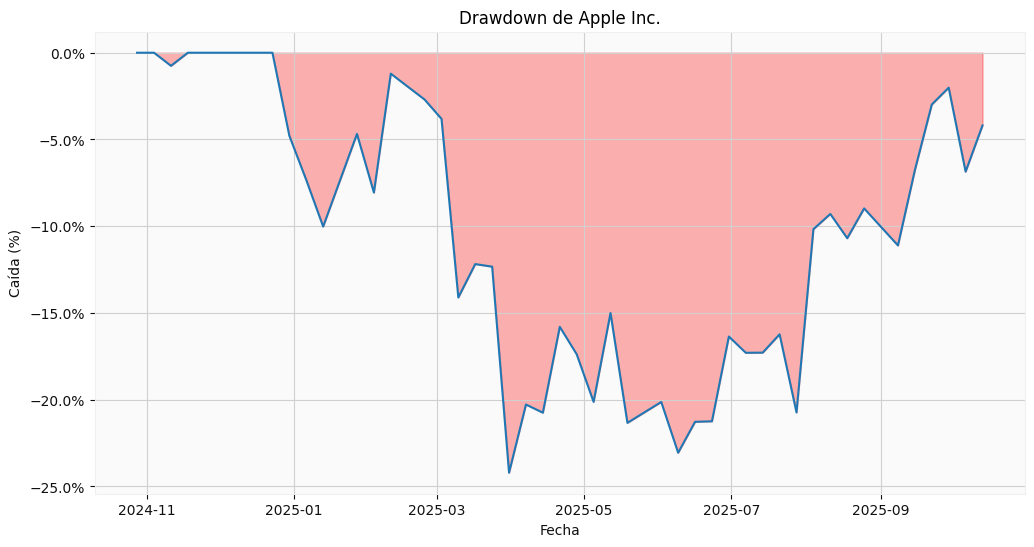

In [ ]:
df_risk_metrics = None

if 'df_history' not in globals() or df_history is None or df_history.empty:
    print("❌ Error: 'df_history' no existe o está vacío.")
    print("   Por favor, ejecuta la Celda 8 (Historial de Precios) y presiona 'Obtener Datos' primero.")
elif 'stock' not in globals() or stock is None:
    print("❌ Error: 'stock' no existe.")
    print("   Por favor, ejecuta la Celda 5 (Input del Ticker) primero.")
elif 'RFR_MX' not in globals() or 'RFR_US' not in globals():
    print("❌ Error: 'RFR_MX' o 'RFR_US' no existen.")
    print("   Por favor, ejecuta la Celda 4 (Obtención de AMBAS Tasas) primero.")
else:
    try:
        if stock.ticker.endswith('.MX'):
            rfr_anual = RFR_MX / 100.0
            benchmark_ticker = '^MXX'
            market_name = 'IPC (^MXX)'
        else:
            rfr_anual = RFR_US
            benchmark_ticker = '^GSPC'
            market_name = 'S&P 500 (^GSPC)'

        rfr_diaria = (1 + rfr_anual)**(1/252) - 1

        start_date = df_history.index.min()
        end_date = df_history.index.max()
        benchmark_data = yf.Ticker(benchmark_ticker).history(start=start_date, end=end_date, interval=df_history.index.freqstr or '1d')

        df_returns = df_history['Close'].pct_change().dropna()
        benchmark_returns = benchmark_data['Close'].pct_change().dropna()

        aligned_df = pd.DataFrame({'stock': df_returns, 'benchmark': benchmark_returns}).dropna()

        stock_excess_returns = aligned_df['stock'] - rfr_diaria
        benchmark_excess_returns = aligned_df['benchmark'] - rfr_diaria

        mean_return_diario = aligned_df['stock'].mean()
        mean_return_anualizado = (1 + mean_return_diario)**252 - 1
        std_return_diario = aligned_df['stock'].std()
        volatilidad_anualizada = std_return_diario * np.sqrt(252)

        var_95 = np.percentile(aligned_df['stock'], 5)
        var_99 = np.percentile(aligned_df['stock'], 1)
        cvar_95 = aligned_df['stock'][aligned_df['stock'] <= var_95].mean()
        skewness = aligned_df['stock'].skew()
        kurtosis = aligned_df['stock'].kurtosis()

        retorno_acumulado = (1 + aligned_df['stock']).cumprod()
        pico_anterior = retorno_acumulado.cummax()
        drawdown = (retorno_acumulado - pico_anterior) / pico_anterior
        max_drawdown = drawdown.min()

        sharpe_ratio_anualizado = np.nan
        if volatilidad_anualizada != 0:
             sharpe_ratio_anualizado = (mean_return_anualizado - rfr_anual) / volatilidad_anualizada

        retornos_negativos = aligned_df['stock'][aligned_df['stock'] < rfr_diaria]
        sortino_ratio_anualizado = np.nan
        if not retornos_negativos.empty:
            varianza_negativa = ((retornos_negativos - rfr_diaria)**2).mean()
            if varianza_negativa > 0:
                downside_deviation_anualizado = np.sqrt(varianza_negativa) * np.sqrt(252)
                if downside_deviation_anualizado != 0:
                    sortino_ratio_anualizado = (mean_return_anualizado - rfr_anual) / downside_deviation_anualizado

        calmar_ratio = np.nan
        if max_drawdown != 0:
             calmar_ratio = mean_return_anualizado / abs(max_drawdown)

        X = benchmark_excess_returns
        Y = stock_excess_returns
        beta = np.nan
        alpha_anualizado = np.nan
        treynor_ratio = np.nan
        r_squared = np.nan
        if len(X) > 1 and len(Y) > 1:
            X_with_const = sm.add_constant(X)
            try:
                model = sm.OLS(Y, X_with_const).fit()
                alpha_diario = model.params.iloc[0]
                beta = model.params.iloc[1]
                r_squared = model.rsquared
                alpha_anualizado = (1 + alpha_diario)**252 - 1
                if beta != 0:
                     treynor_ratio = (mean_return_anualizado - rfr_anual) / beta
            except Exception as reg_e:
                 print(f"⚠️ Advertencia: No se pudo calcular Alpha/Beta. Error de regresión: {reg_e}")


        raw_metrics = {
            'Retorno Anualizado': mean_return_anualizado,
            'Volatilidad Anualizada': volatilidad_anualizada,
            'Sharpe Ratio (Anualizado)': sharpe_ratio_anualizado,
            'Sortino Ratio (Anualizado)': sortino_ratio_anualizado,
            'Calmar Ratio': calmar_ratio,
            'Max Drawdown': max_drawdown,
            'Beta (β)': beta,
            'Alpha (α) Anualizado': alpha_anualizado,
            'Treynor Ratio': treynor_ratio,
            'R-squared (R²)': r_squared,
            'VaR 95% (Diario)': var_95,
            'VaR 99% (Diario)': var_99,
            'CVaR 95% (Diario)': cvar_95,
            'Skewness (Asimetría)': skewness,
            'Kurtosis (Exceso)': kurtosis
        }
        df_risk_metrics = pd.DataFrame.from_dict(raw_metrics, orient='index', columns=['Valor'])

        formatted_metrics = {
            'Retorno Anualizado': f"{raw_metrics['Retorno Anualizado']:.2%}" if not np.isnan(raw_metrics['Retorno Anualizado']) else 'N/A',
            'Volatilidad Anualizada': f"{raw_metrics['Volatilidad Anualizada']:.2%}" if not np.isnan(raw_metrics['Volatilidad Anualizada']) else 'N/A',
            '--- Ratios vs. Riesgo Total ---': '---',
            'Sharpe Ratio (Anualizado)': f"{raw_metrics['Sharpe Ratio (Anualizado)']:.2f}" if not np.isnan(raw_metrics['Sharpe Ratio (Anualizado)']) else 'N/A',
            'Sortino Ratio (Anualizado)': f"{raw_metrics['Sortino Ratio (Anualizado)']:.2f}" if not np.isnan(raw_metrics['Sortino Ratio (Anualizado)']) else 'N/A',
            'Calmar Ratio': f"{raw_metrics['Calmar Ratio']:.2f}" if not np.isnan(raw_metrics['Calmar Ratio']) else 'N/A',
            'Max Drawdown': f"{raw_metrics['Max Drawdown']:.2%}" if not np.isnan(raw_metrics['Max Drawdown']) else 'N/A',
            '--- Ratios vs. Mercado ---': f'(vs. {market_name})',
            'Beta (β)': f"{raw_metrics['Beta (β)']:.3f}" if not np.isnan(raw_metrics['Beta (β)']) else 'N/A',
            'Alpha (α) Anualizado': f"{raw_metrics['Alpha (α) Anualizado']:.2%}" if not np.isnan(raw_metrics['Alpha (α) Anualizado']) else 'N/A',
            'Treynor Ratio': f"{raw_metrics['Treynor Ratio']:.3f}" if not np.isnan(raw_metrics['Treynor Ratio']) else 'N/A',
            'R-squared (R²)': f"{raw_metrics['R-squared (R²)']:.2%}" if not np.isnan(raw_metrics['R-squared (R²)']) else 'N/A',
            '--- Métricas de Cola ---': '---',
            'VaR 95% (Diario)': f"{raw_metrics['VaR 95% (Diario)']:.2%}" if not np.isnan(raw_metrics['VaR 95% (Diario)']) else 'N/A',
            'VaR 99% (Diario)': f"{raw_metrics['VaR 99% (Diario)']:.2%}" if not np.isnan(raw_metrics['VaR 99% (Diario)']) else 'N/A',
            'CVaR 95% (Diario)': f"{raw_metrics['CVaR 95% (Diario)']:.2%}" if not np.isnan(raw_metrics['CVaR 95% (Diario)']) else 'N/A',
            'Skewness (Asimetría)': f"{raw_metrics['Skewness (Asimetría)']:.3f}" if not np.isnan(raw_metrics['Skewness (Asimetría)']) else 'N/A',
            'Kurtosis (Exceso)': f"{raw_metrics['Kurtosis (Exceso)']:.3f}" if not np.isnan(raw_metrics['Kurtosis (Exceso)']) else 'N/A'
        }
        df_display_metrics = pd.DataFrame.from_dict(formatted_metrics, orient='index', columns=['Valor'])
        df_display_metrics.index.name = 'Métrica de Riesgo y Desempeño'

        display(HTML(f'<h3>11. Análisis Avanzado de Riesgo y Desempeño</h3>'))
        display(df_display_metrics)

        display(HTML('<h4>Gráfica de Drawdown (Caída desde el Pico)</h4>'))
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(drawdown.index, drawdown * 100)
        ax.fill_between(drawdown.index, drawdown * 100, 0, alpha=0.3, color='red')

        ax.set_title(f'Drawdown de {info_empresa.get("shortName", stock.ticker)}')

        ax.set_ylabel('Caída (%)')
        ax.set_xlabel('Fecha')
        ax.grid(True)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.show()

    except Exception as e:
         print(f"❌ Ocurrió un error al calcular las métricas avanzadas: {e}")
         df_risk_metrics = pd.DataFrame()

# Conclusión y Próximos Pasos

## Resumen

Este entorno le ha proporcionado dos flujos de trabajo eficientes para analizar acciones:

1.  **Reporte Automatizado (Celda 0):** Una solución rápida para generar y descargar un reporte completo en Excel con la información fundamental y de mercado esencial de una empresa.
2.  **Análisis Interactivo (Celdas 1+):** Un recorrido detallado que le permite visualizar cada componente del análisis, desde los estados financieros hasta métricas avanzadas de riesgo y desempeño, directamente en Colab.

Hemos cubierto la extracción de datos financieros históricos, ratios clave, información de propiedad, eventos corporativos y métricas de riesgo ajustado como Sharpe, Sortino, Alpha y Beta.

## Próximos Pasos

Este notebook es una base sólida. Algunas ideas para expandir su funcionalidad podrían incluir:

* **Comparación entre Empresas:** Modificar el flujo para analizar y comparar dos o más tickers simultáneamente.
* **Análisis Sectorial:** Integrar datos del sector o industria para contextualizar el desempeño de la empresa.
* **Modelos de Valuación:** Añadir celdas para calcular modelos simples como el Descuento de Flujos de Caja (DCF) o valuación por múltiplos.
* **Visualizaciones Avanzadas:** Utilizar bibliotecas como Plotly o Seaborn para crear gráficos interactivos más sofisticados.

Esperamos que esta herramienta le sea de gran utilidad en sus análisis financieros. ¡Éxito!